# Benchmark of 4D phase space reconstruction algorithms 

In [4]:
import sys
import importlib
import numpy as np
from skimage import filters
from matplotlib import pyplot as plt
import proplot as pplt
from tqdm import tqdm
from tqdm import trange

import plotting as rplot

sys.path.append('../../')
from tools import plotting as myplt
from tools import beam_analysis as ba
from tools import ap_utils
from tools import utils
from measurement.tomography import reconstruct as rec

In [5]:
pplt.rc['axes.grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'mono_r'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid.alpha'] = 0.04

## Setup 

Load the distribution to be reconstructed.

In [6]:
X = np.loadtxt('/Users/austin/Dropbox/SCBD/scratch/RUN_0167/data/Bm_Parts_0_300')
X = X[:, :4]
X -= np.mean(X, axis=0)

Compute the 2D Twiss parameters; normalize $x$-$x'$ and $y$-$y'$.

In [7]:
Sigma = np.cov(X.T)
alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(Sigma)
print('Statistical Twiss parameters:')
print('  alpha_x = {}'.format(alpha_x))
print('  alpha_y = {}'.format(alpha_y))
print('  beta_x = {}'.format(beta_x))
print('  beta_y = {}'.format(beta_y))

# Define the lattice Twiss parameters. (If `dalpha` and `dbeta` are nonzero, 
# the lattice Twiss parameters will be different than the statistical Twiss
# parameters. 
np.random.seed(17)
dalpha = 0.0
dbeta = 0.0 * max(beta_x, beta_y)
alpha_x += np.random.uniform(-dalpha, dalpha)
alpha_y += np.random.uniform(-dalpha, dalpha)
beta_x += np.random.uniform(-dbeta, dbeta)
beta_y += np.random.uniform(-dbeta, dbeta)
print('Lattice Twiss parameters:')
print('  alpha_x = {}'.format(alpha_x))
print('  alpha_y = {}'.format(alpha_y))
print('  beta_x = {}'.format(beta_x))
print('  beta_y = {}'.format(beta_y))

V = ap_utils.V_matrix_4x4_uncoupled(alpha_x, alpha_y, beta_x, beta_y)
Vinv = np.linalg.inv(V)
Xn = utils.apply(Vinv, X)

Statistical Twiss parameters:
  alpha_x = 0.00273832682072681
  alpha_y = 0.12530987414556008
  beta_x = 22.701313304703437
  beta_y = 11.875058582880387
Lattice Twiss parameters:
  alpha_x = 0.00273832682072681
  alpha_y = 0.12530987414556008
  beta_x = 22.701313304703437
  beta_y = 11.875058582880387


Bin the normalized coordinates at the reconstruction location.

In [8]:
n_bins = 75

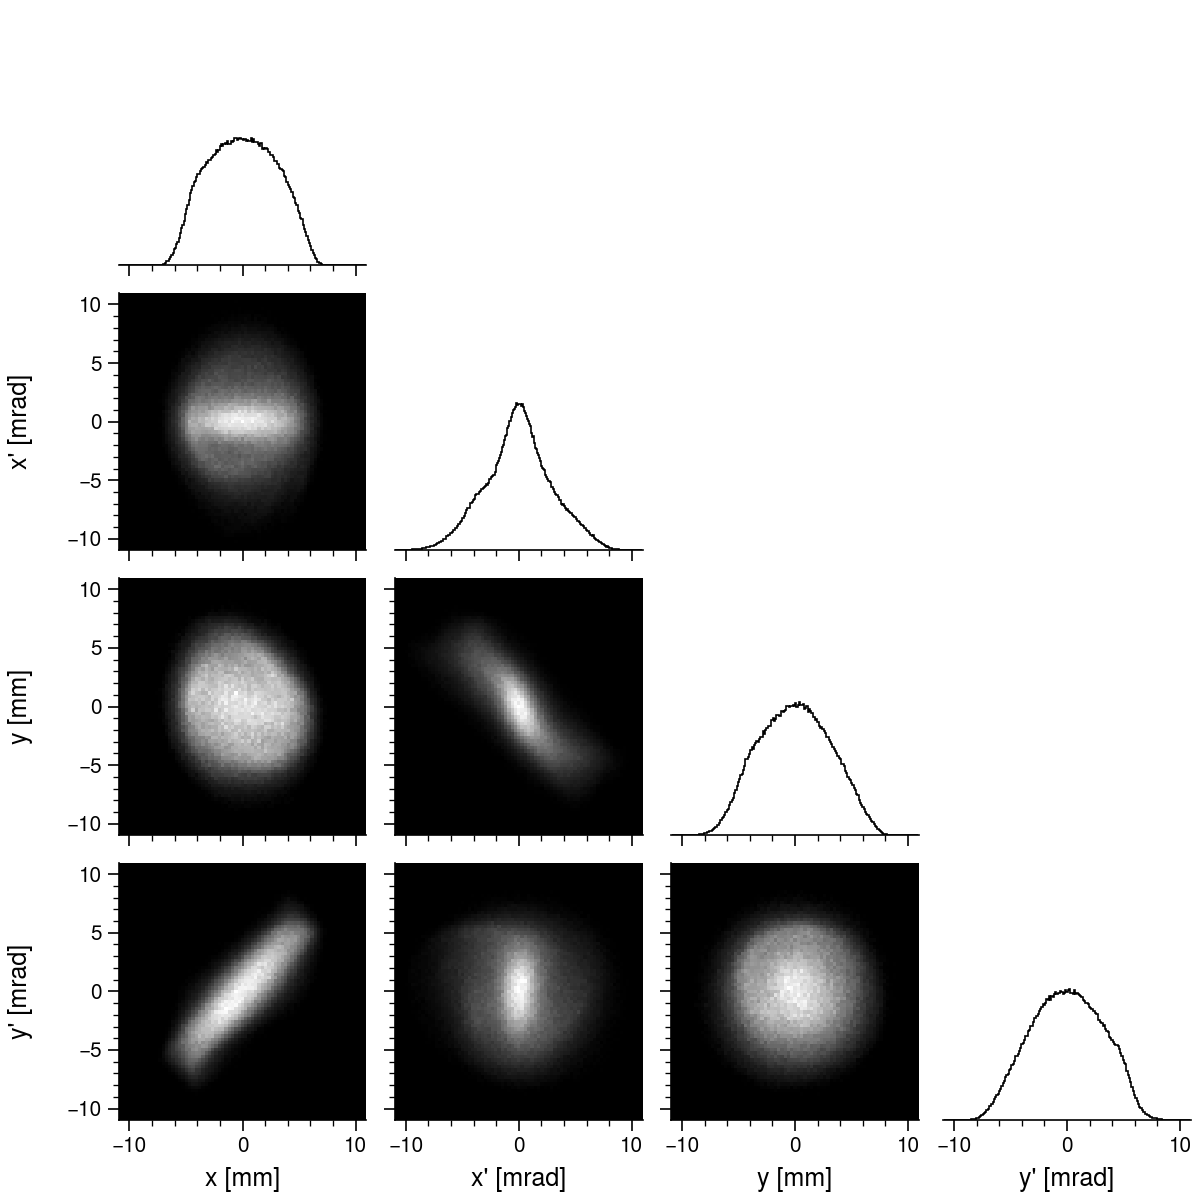

In [9]:
axes = myplt.corner(Xn, figsize=(6, 6), bins=n_bins, autolim_kws=dict(sigma=3.5))
rec_limits = [ax.get_xlim() for ax in axes[-1, :]]

In [10]:
Z_true, rec_edges = np.histogramdd(Xn, n_bins, rec_limits, density=True)
rec_centers = [rec.get_bin_centers(_edges) for _edges in rec_edges]
bin_volume = rec.get_bin_volume(rec_limits, n_bins)

Transport the distribution to the screen. Since the horizontal and vertical optics are varied independently, we can transport $x$-$x'$ and $y$-$y'$ independently. Assume the phase advances are evenly spaced over 180 degrees. The Twiss parameters at the screen are randomly chosen in a realistic range.

In [11]:
def make_tmats(phase_advances, betas, alphas, Vinv):
    """Return list of 2x2 transfer matrices."""
    tmats = []
    for phase_adv, beta, alpha in zip(phase_advances, betas, alphas):
        P = utils.rotation_matrix(phase_adv)
        V_screen = ap_utils.V_matrix_2x2(alpha, beta)
        tmats.append(np.linalg.multi_dot([V_screen, P, Vinv]))
    return tmats

In [12]:
K = 15 # number of horizontal optics settings
L = 15 # number of vertical optics settings

phase_adv_x = np.linspace(0.0, np.pi, K, endpoint=False)
betas_x = np.random.uniform(55.0, 70.0, size=K)
alphas_x = np.random.uniform(0.0, 1.0, size=K)

phase_adv_y = np.linspace(0.0, np.pi, L, endpoint=False)
betas_y = np.random.uniform(5.5, 6.5, size=L)
alphas_y = np.random.uniform(-1.0, 0.0, size=L)

tmats_x = make_tmats(phase_adv_x, betas_x, alphas_x, Vinv[:2, :2])
tmats_y = make_tmats(phase_adv_y, betas_y, alphas_y, Vinv[2:, 2:])
xx_list = [utils.apply(Mx, X[:, :2])[:, 0] for Mx in tmats_x]
yy_list = [utils.apply(My, X[:, 2:])[:, 0] for My in tmats_y]

Bin the coordinates on the screen.

In [13]:
xmax_screen = ymax_screen = 75.0 # [mm]
meas_edges = [
    np.linspace(-xmax_screen, xmax_screen, n_bins + 1),
    np.linspace(-xmax_screen, xmax_screen, n_bins + 1),
]
meas_centers = [rec.get_bin_centers(_edges) for _edges in meas_edges]

In [14]:
S = np.zeros((n_bins, n_bins, K, L))
for k, xx in enumerate(tqdm(xx_list)):
    for l, yy in enumerate(yy_list):
        S[:, :, k, l], _, _ = np.histogram2d(xx, yy, meas_edges)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.11it/s]


In [15]:
# fig, axes = pplt.subplots(nrows=3, ncols=5, figwidth=8.5, space=0.25)
# for k, ax in enumerate(axes):
#     ax.pcolormesh(S[:, :, k, 0].T, cmap='mono_r', ec='None')
#     ax.annotate(r'$\mu_x = {:.0f}\degree$'.format(np.degrees(phase_adv_x[k])), 
#                 xy=(0.01, 0.93), xycoords='axes fraction', color='white', fontsize='small')
# axes.format(xlabel=r"$x$", ylabel=r"$y$", xticks=[], yticks=[])
# plt.savefig('_output/tomo_sim_target_scan.png', dpi=500)
# plt.show()

In [16]:
# fig, axes = pplt.subplots(nrows=K, ncols=L, figwidth=10, space=0.1)
# for i in range(axes.shape[0]):
#     for j in range(axes.shape[1]):
#         ax = axes[i, j]
#         ax.pcolormesh(S[:, :, i, j].T, cmap='mono_r', ec='None')
# axes.format(
#     xticks=[], yticks=[], 
# #     xlabel='x', ylabel='y',
# )
# plt.savefig('_output/tomo_sim_target_scan_full.png', dpi=500)
# plt.show()

## Hock's method

We'll reconstruct in normalized phase space.

In [17]:
tmats_x_n = [np.matmul(Mx, V[:2, :2]) for Mx in tmats_x]
tmats_y_n = [np.matmul(My, V[2:, 2:]) for My in tmats_y]

In [18]:
Z_hock = rec.hock4D(S, meas_centers, [rec_centers[0], rec_centers[2]], 
                    tmats_x_n, tmats_y_n, method='SART', iterations=2)
Z_hock = rec.process(Z_hock, keep_positive=True, density=True, limits=rec_limits)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 75/75 [01:17<00:00,  1.04s/it]


In [19]:
print('min(Z) = {}'.format(np.min(Z_hock)))
print('max(Z) = {}'.format(np.max(Z_hock)))
print('sum(Z) * bin_volume = {}'.format(np.sum(Z_hock) * bin_volume))
print()
print('min(Z_true) = {}'.format(np.min(Z_true)))
print('max(Z_true) = {}'.format(np.max(Z_true)))
print('sum(Z_true) * bin_volume = {}'.format(np.sum(Z_true) * bin_volume))

min(Z) = 0.0
max(Z) = 0.0006112300027812082
sum(Z) * bin_volume = 1.0000000000000013

min(Z_true) = 0.0
max(Z_true) = 0.002284455415379779
sum(Z_true) * bin_volume = 1.000000000000005


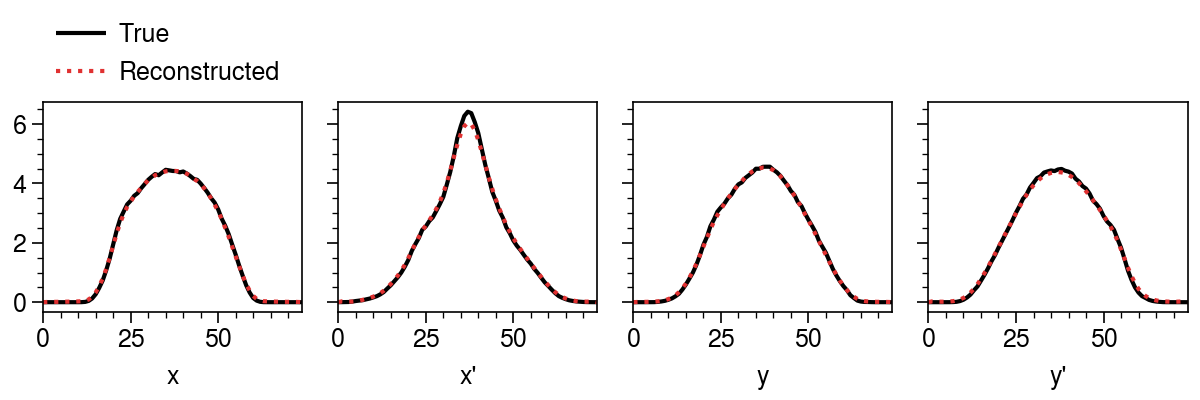

In [20]:
axes = rplot.compare_1D(Z_hock, Z_true)
plt.savefig('_output/tomo_sim_rec_hock_proj_1D.png', dpi=500)

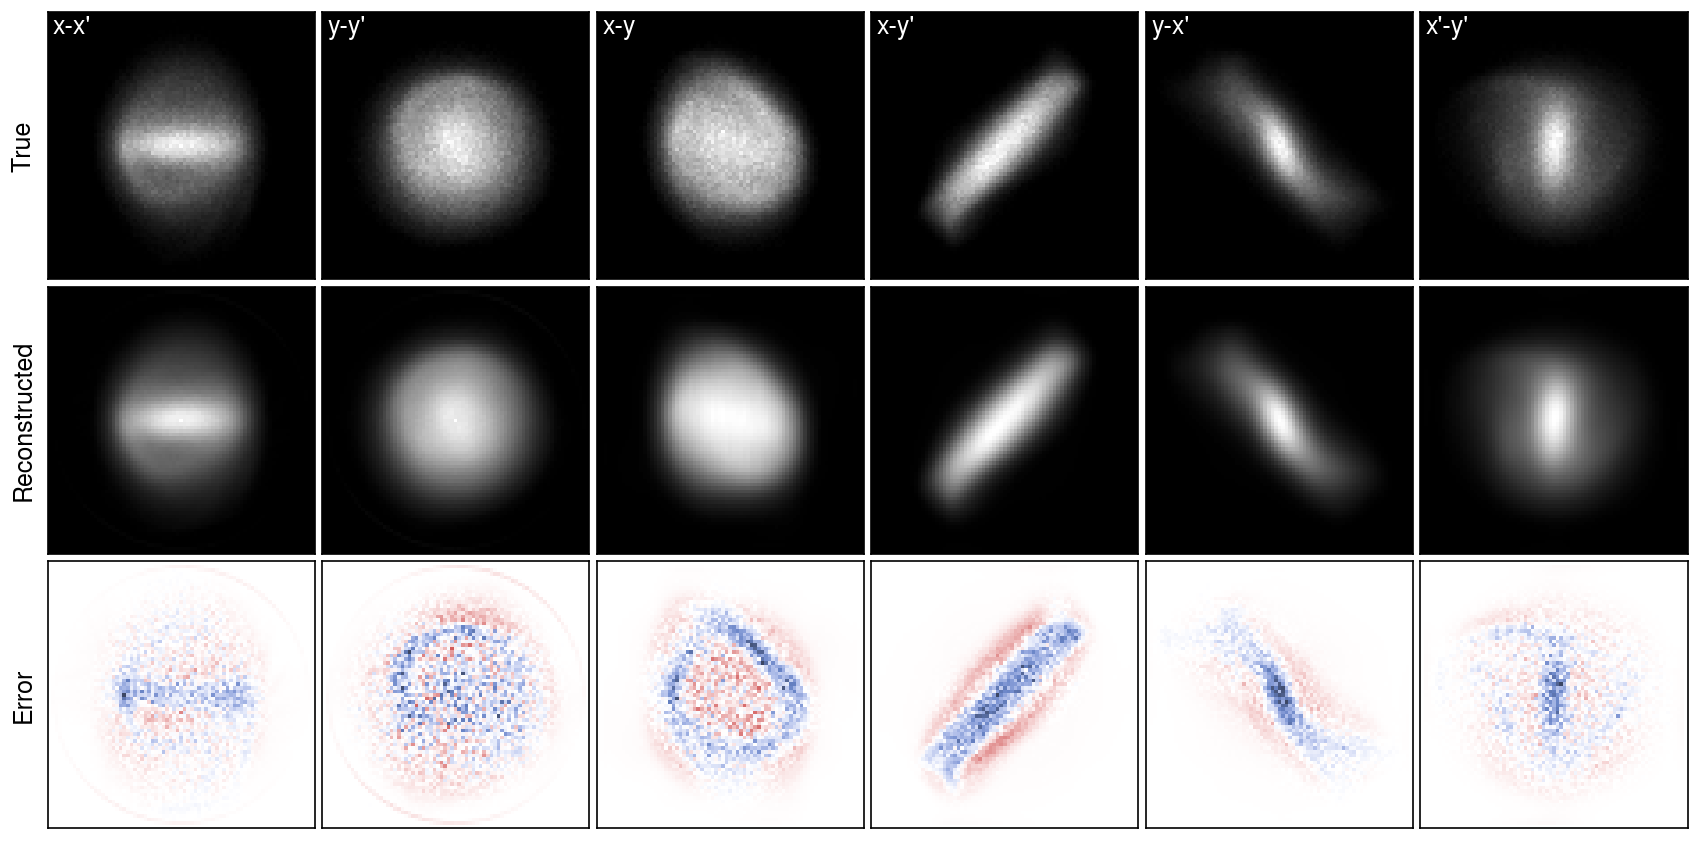

In [21]:
axes = rplot.compare_hor(Z_hock, Z_true, cmap_div='div')
plt.savefig('_output/tomo_sim_rec_hock_proj_2D_hor.png', dpi=500)
plt.show()

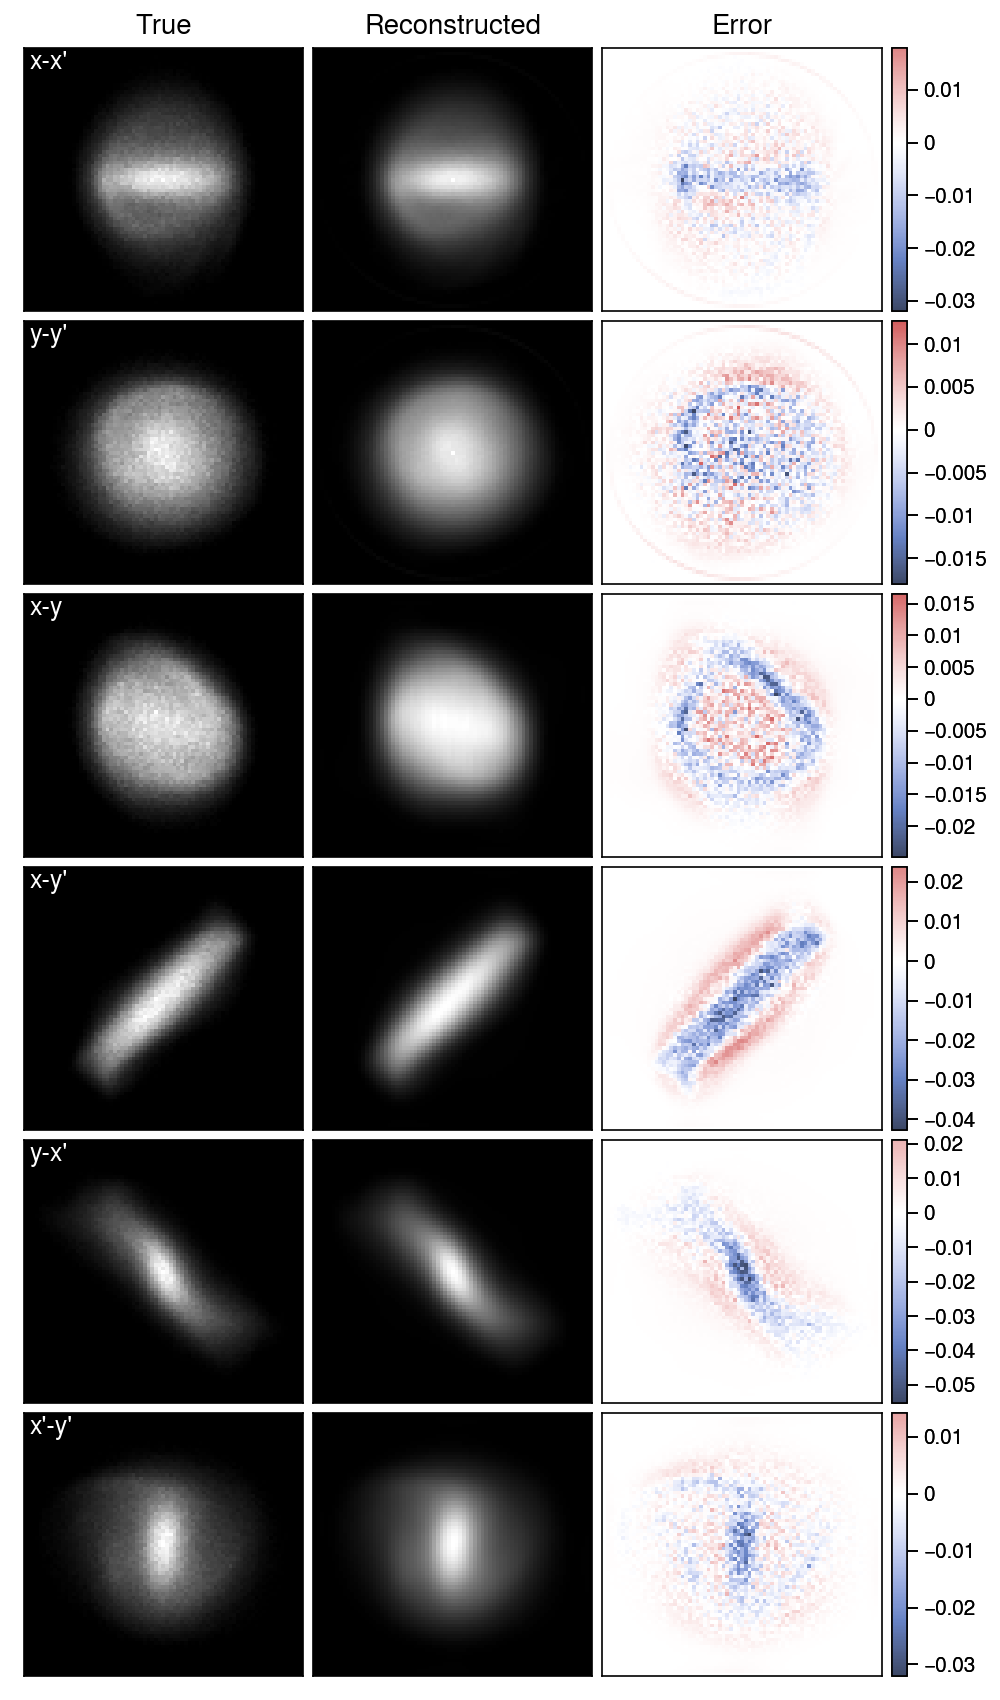

In [22]:
axes = rplot.compare_ver(Z_hock, Z_true, space=0.4, cmap_div='div')
plt.savefig('_output/tomo_sim_rec_hock_proj_2D_ver.png', dpi=500)
plt.show()

Transform to unnormalized phase space.

Study 2D reconstruction as function of number of angles and of the angular range.

In [ ]:
# from skimage.transform import radon, iradon_sart

# i1, i2 = 2, 3
# bins = 50
# z_true, _, _ = np.histogram2d(Xn[:, i1], Xn[:, i2], bins, [limits[i1], limits[i2]], density=True)

# n_proj_list = np.arange(3, 30)
# max_angles = np.linspace(5., 180., 50, endpoint=False)
# errors = np.zeros((len(n_proj_list), len(max_angles)))    
# for i in trange(errors.shape[0]):
#     for j in range(errors.shape[1]):
#         angles = np.linspace(0., max_angles[j], n_proj_list[i])
#         projections = radon(z_true, theta=angles, circle=True)
#         z = iradon_sart(projections, theta=angles)
#         z = iradon_sart(projections, theta=angles, image=z)
#         z = rec.process(z, keep_positive=True, density=True, limits=[limits[i1], limits[i2]])
#         # if i == 0:
#         #     fig, axes = pplt.subplots(ncols=2)
#         #     axes[0].pcolormesh(xedges, yedges, Z_true.T, cmap='viridis',)
#         #     axes[1].pcolormesh(xedges, yedges, Z.T, cmap='viridis',)
#         #     plt.show()
#         errors[i, j] = np.sqrt(np.sum((z - z_true)**2))

In [ ]:
# fig, ax = pplt.subplots()
# ax.pcolormesh(
#     n_proj_list, max_angles, errors.T, cmap=pplt.Colormap('mono'), 
#     vmin=0,
#     colorbar=True, 
#     colorbar_kw=dict(label=r'$\Vert Z - Z_{true} \Vert$', width=0.1, space=1.0)
# )
# ax.format(yformatter='deg', ylabel='Angular range', xlabel='Number of projections')
# plt.savefig('_output/tomo_sim_art2d.png', dpi=350)
# plt.show()

## 4D ART 

The maximum reconstruction grid resolution for this method is approximately 50.

In [23]:
n_bins = 10
Z_true2, rec_edges = np.histogramdd(Xn, n_bins, rec_limits, density=True)
rec_centers = [rec.get_bin_centers(_edges) for _edges in rec_edges]
bin_volume = rec.get_bin_volume(rec_limits, n_bins)

In [ ]:
K = 8 # number of angles in x dimension
L = 8 # number of angles in y dimension

tmats

In [ ]:
sigma = 0.0 # Gaussian blur
projections, tmats = [], []
for k, xx in enumerate(tqdm(xx_list)):
    for l, yy in enumerate(yy_list):
        z, _, _ = np.histogram2d(xx, yy, n_bins, (limits[0], limits[2]))
        z = filters.gaussian(z, sigma)
        projections.append(z)
        M = np.zeros((4, 4))
        M[:2, :2] = tmats_x[k]
        M[2:, 2:] = tmats_y[l]
        tmats.append(M)

In [ ]:
Z = rec.art4D(projections, tmats, rec_grid_centers, (screen_edges_x, screen_edges_y))

In [ ]:
Z = rec.process(Z, keep_positive=True, density=True, limits=limits)

In [ ]:
fig, axes = pplt.subplots(ncols=4, figsize=(6, 2), spanx=False)
labels = ["x", "x'", "y", "y'"]
for i in range(4):
    axes[i].plot(centers[i], rec.project(Z_true2, i), color='black', label='True')
    axes[i].plot(centers[i], rec.project(Z, i), color='red8', ls='dotted', label='Reconstructed')
    axes[i].set_xlabel(labels[i])
axes[0].legend(loc=(0.0, 1.02), framealpha=0.0, ncol=1);
plt.savefig('_output/tomo_sim_rec_art_proj1D.png', dpi=350)
plt.show()

In [ ]:
plot_kws = dict(cmap=cmap)
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=3, ncols=6, figwidth=8.5, sharex=False, sharey=False, space=0.3)
for col, (i, j) in enumerate(indices):
    _Z_true = rec.project(Z_true2, [i, j])
    _Z = rec.project(Z, [i, j])
    axes[0, col].pcolormesh(centers[i], centers[j], _Z_true.T, **plot_kws)
    axes[1, col].pcolormesh(centers[i], centers[j], _Z.T, **plot_kws)
    axes[2, col].pcolormesh(centers[i], centers[j], (_Z - _Z_true).T)
    axes[0, col].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white', 
                          fontsize='medium')
for ax, title in zip(axes[:, 0], ['True', 'Reconstructed', 'Error']):
    ax.set_ylabel(title)
axes.format(xticks=[], yticks=[])
plt.savefig('_output/tomo_sim_rec_art_proj_2D_hor.png', dpi=500)
plt.show()

In [ ]:
plot_kws = dict(cmap='mono_r', robust=False)
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=6, ncols=3, figsize=(5.0, 8.5), 
                          sharex=False, sharey=False, space=0.5)
for row, (i, j) in enumerate(indices):
    _Z_true = rec.project(Z_true, [i, j])
    _Z = rec.project(Z, [i, j])
    _Z_true2 = rec.project(Z_true2, [i, j])
    axes[row, 0].pcolormesh(_Z_true.T, **plot_kws)
    axes[row, 1].pcolormesh(centers[i], centers[j], _Z.T, **plot_kws)
    axes[row, 2].pcolormesh(centers[i], centers[j], (_Z - _Z_true2).T, 
                            colorbar=True, 
                            colorbar_kw=dict(width=0.075, space=1.0, ticklabelsize='small')
                           )
    axes[row, 0].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white', 
                          fontsize='medium')
for ax, title in zip(axes[0, :], ['True', 'Reconstructed', 'Error']):
    ax.set_title(title)
axes.format(xticks=[], yticks=[])
plt.savefig('_output/tomo_sim_rec_art_proj2D.png', dpi=350)
plt.show()

## Particle-based

In [ ]:
importlib.reload(rec)

In [ ]:
projections = []
tmats = []
for k in np.arange(0, 15, 2):
    for l in np.arange(0, 15, 2):
        projections.append(S[:, :, k, l])
        M = np.zeros((4, 4))
        M[:2, :2] = tmats_x[k]
        M[2:, 2:] = tmats_y[l]
        tmats.append(M)
Z_pic, _proj = rec.pic4D(projections, tmats, rec_centers, screen_edges, max_iters=15)

In [ ]:
compare(Z_pic, Z_true)